In [50]:
%pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint




Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\ANJA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [51]:
#Dataset
#%pip install kagglehub
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

#print("Path to dataset files:", path)

In [52]:
train_val_data_dir = r'..\images\train'
# train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128

# train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',  # subfolderi - labele
    label_mode='categorical',   # labele - kao one hot encod
    validation_split=0.2, 
    subset = 'training',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
    #interpolation='bilinear' # opciono - metod, kod nas ne radimo resizing
)

train_class_names = train_ds.class_names
print(train_class_names)  

# validation DS (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',     
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_class_names = val_ds.class_names
print(val_class_names) 


# test DS
test_data_dir = r'..\images\test'
# test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)



Found 28821 files belonging to 7 classes.
Using 23057 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Broj slika u originalnom datasetu:
        - training 28821
        - validation (test kod nas) 7066

Za prebrojavanje slika po kategorijama:

In [53]:
def count_labels(dataset):
    counts = dict.fromkeys(dataset.class_names, 0)
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[dataset.class_names[i]] += 1
    return counts

In [54]:
print("Train dataset:", count_labels(train_ds))
print("Validation dataset:", count_labels(val_ds))
print("Test dataset:", count_labels(test_ds))

Train dataset: {'angry': 3229, 'disgust': 341, 'fear': 3294, 'happy': 5765, 'neutral': 3941, 'sad': 3935, 'surprise': 2552}
Validation dataset: {'angry': 764, 'disgust': 95, 'fear': 809, 'happy': 1399, 'neutral': 1041, 'sad': 1003, 'surprise': 653}
Test dataset: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


Prikaz prvih slika po kategorijama iz prvog batch-a: (random)

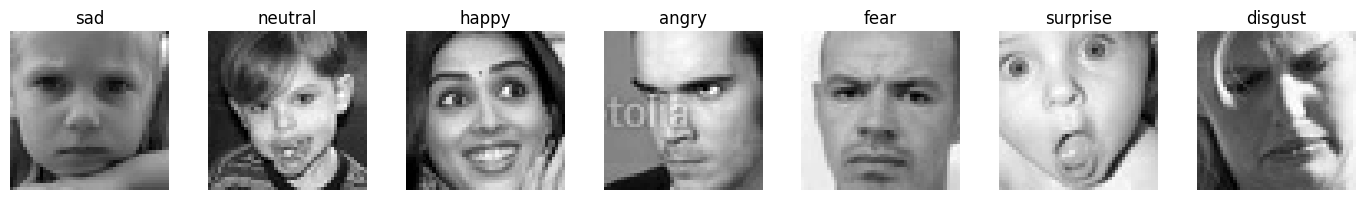

In [55]:

for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    class_names = train_ds.class_names

    first_of_class = {}  # prva slika po klasi

    for i in range(len(images)):
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]

        if class_name not in first_of_class:
            first_of_class[class_name] = images[i]

        if len(first_of_class) == len(class_names):
            break

    # broj klasa
    n_classes = len(class_names)
    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona

    for ax, (class_name, image) in zip(axes, first_of_class.items()):
        ax.imshow(image.squeeze(), cmap='gray')  # squeeze ako je grayscale
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Normalizacija:

In [56]:
def normalize_images(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 0) / (255 - 0)      # min-max normalizacija
    return x, y

# primjena na sve dataset-ove
train_ds = train_ds.map(normalize_images)
val_ds   = val_ds.map(normalize_images)
test_ds  = test_ds.map(normalize_images)

Provjera px:

Train set - Min pixel: 0.0, Max pixel: 1.0
Validation set - Min pixel: 0.0, Max pixel: 1.0
Test set - Min pixel: 0.0, Max pixel: 1.0


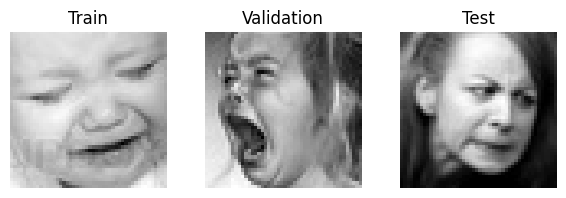

In [57]:
def show_first_images_in_row(train_ds, val_ds, test_ds):
    datasets = [train_ds, val_ds, test_ds]
    names = ["Train", "Validation", "Test"]
    images_to_show = []

    # uzmi prvu sliku iz svakog skupa
    for dataset, name in zip(datasets, names):
        for images, labels in dataset.take(1):
            image = images[0].numpy().squeeze()  # prva slika
            min_val = tf.reduce_min(images).numpy()
            max_val = tf.reduce_max(images).numpy()
            print(f"{name} set - Min pixel: {min_val}, Max pixel: {max_val}")
            images_to_show.append((image, name))

    # prikazi slike u jednom redu
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(len(images_to_show)*2, 2))
    for ax, (image, name) in zip(axes, images_to_show):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_images_in_row(train_ds, val_ds, test_ds)


Augmentacija train seta:

In [58]:
# Data augmentation - pozvati u modelu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    #layers.RandomZoom(0.1)
])

In [59]:
def preprocess_to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)  # 1 kanal -> 3 kanala
    return img, label

train_ds_rgb = train_ds.map(preprocess_to_rgb)
val_ds_rgb = val_ds.map(preprocess_to_rgb)
test_ds_rgb = test_ds.map(preprocess_to_rgb)

for x, y in train_ds_rgb.take(1):
    print(x.shape)  # Trebalo bi da bude (batch_size, img_height, img_width, 3)


(128, 48, 48, 3)


**VGG 19:**
parametri (podesiti, i iz radova) i rez, analiza, fine tuning! ako mijenjamo dim slika da li to za svaki model drugacije

In [14]:
# Parametri
img_height = 48  # 2. vece slike za VGG19 ?
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-4

# Data augmentation 3.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    #layers.RandomZoom(0.1)
])

# VGG19 feature extractor
VGG19_model = VGG19(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in VGG19_model.layers:
    layer.trainable = False

# Build model
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # augmentacija
x = VGG19_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)  # manje parametara nego Flatten
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x) #4.

model = models.Model(inputs, outputs)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])


# Early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)


# Train model
history = model.fit(train_ds_rgb, validation_data=val_ds_rgb, epochs=50, callbacks=[early_stop, model_checkpoint])


# Evaluate on test set
best_model = load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report - 5. f1 samo za test ispis?
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)      #vjerovatnoce svake klase za svaki primjer
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.1889 - auc: 0.5525 - loss: 2.2024 - precision: 0.2430 - recall: 0.0420 - val_accuracy: 0.2892 - val_auc: 0.6633 - val_loss: 1.8192 - val_precision: 0.6310 - val_recall: 0.0092
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.2450 - auc: 0.6178 - loss: 1.9693 - precision: 0.3566 - recall: 0.0432 - val_accuracy: 0.3132 - val_auc: 0.6918 - val_loss: 1.7723 - val_precision: 0.5812 - val_recall: 0.0236
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.2752 - auc: 0.6530 - loss: 1.8716 - precision: 0.4353 - recall: 0.0456 - val_accuracy: 0.3295 - val_auc: 0.7109 - val_loss: 1.7356 - val_precision: 0.5876 - val_recall: 0.0460
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.2912 - auc: 0.6756 - loss: 1.8140 - precision: 0.4698 - recall: 0.0431 - val_accuracy: 0.3400 - val_auc: 0.7227 - val_loss: 1.7102 - val_precision: 0.6098 - val_recall: 0.0434
Epoch 5/50
181/181 ━━━━━━━━━

KeyboardInterrupt: 

In [32]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])

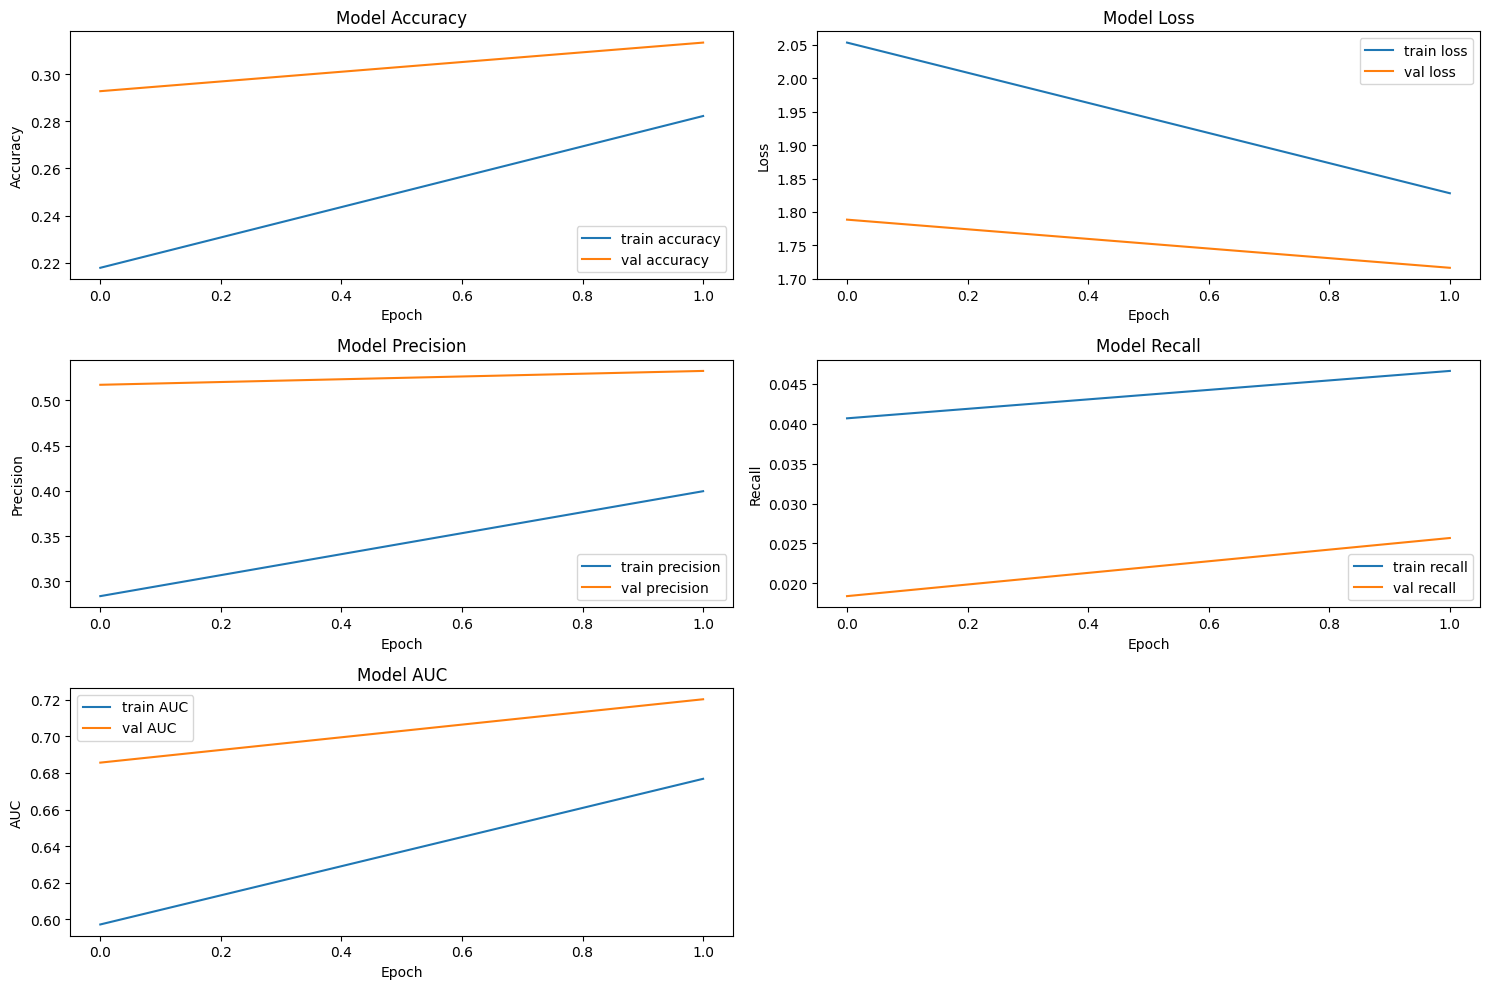

In [33]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# F1
# plt.subplot(3,2,6)
# plt.plot(f1_callback.train_f1, label='train F1')
# plt.plot(f1_callback.val_f1, label='val F1')
# plt.title('F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.legend()


plt.tight_layout()
plt.show()


**EFFICIENT NET B0:**

Resize slika jer modeli zahtijevaju vece, provjeriti!!!

In [47]:
def resize_images(x, y):
    x = tf.image.resize(x, [224, 224])
    return x, y

#train_ds_rgb = train_ds_rgb.map(resize_images)
#val_ds_rgb = val_ds_rgb.map(resize_images)
#test_ds_rgb = test_ds_rgb.map(resize_images)

In [60]:
from tensorflow.keras.applications import EfficientNetB0

img_height = 48  # 2. vece slike za efficientnet ?
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-4

# Data augmentation 3.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    #layers.RandomZoom(0.1)
])


# EfficientNetB0 feature extractor
effnet_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in effnet_model.layers:
    layer.trainable = False

 # Build model
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = effnet_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_effnetb0_model.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(train_ds_rgb, validation_data=val_ds_rgb, epochs=50, callbacks=[early_stop, model_checkpoint])

# Evaluate
best_model = load_model('efficientnet128_model.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [49]:
history.history.keys()

SyntaxError: invalid syntax (130848319.py, line 2)

In [ ]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


RESNET

In [38]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))

for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(48,48,3))
x = data_augmentation(inputs)    
x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

#Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)
loss, acc, prec, rec, auc = model.evaluate(val_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")


Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2356 - auc: 0.6320 - loss: 1.8393 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.2427 - auc: 0.6451 - loss: 1.8161 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2488 - val_auc: 0.6585 - val_loss: 1.8037 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2499 - auc: 0.6575 - loss: 1.8019 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.2564 - auc: 0.6639 - loss: 1.7907 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2785 - val_auc: 0.6783 - val_loss: 1.7736 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2581 - auc: 0.6696 - loss: 1.7853 - precision: 0.4665 - recall: 3.0805e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.2601 - auc: 0.6723 - loss: 1.7795 - precision: 0.5714 - recall: 1.7348e-04 - val_accuracy: 0.2729 - val_auc: 0.6793 - val_loss: 1.7706 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2688 - auc: 0.6765 - loss: 1.7756 - precision: 0.2142 - recall: 5.5316e-05

181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.2720 - auc: 0.6820 - loss: 1.7668 - precision: 0.4000 - recall: 8.6742e-05 - val_accuracy: 0.2732 - val_auc: 0.6915 - val_loss: 1.7544 - val_precision: 0.4000 - val_recall: 6.9396e-04
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2722 - auc: 0.6825 - loss: 1.7672 - precision: 0.3588 - recall: 2.1102e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.2769 - auc: 0.6853 - loss: 1.7621 - precision: 0.6500 - recall: 5.6382e-04 - val_accuracy: 0.2804 - val_auc: 0.6981 - val_loss: 1.7411 - val_precision: 0.3750 - val_recall: 5.2047e-04
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.2826 - auc: 0.6907 - loss: 1.7527 - precision: 0.6316 - recall: 5.2045e-04 - val_accuracy: 0.2935 - val_auc: 0.6942 - val_loss: 1.7464 - val_precision: 0.3750 - val_recall: 5.2047e-04
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.2851 - auc: 0.6921 - loss: 1.7510 - precision: 0.5802 - recall: 0.0017

181/181 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.2816 - auc: 0.6919 - loss: 1.7509 - precision: 0.5952 - recall: 0.0022 - val_accuracy: 0.3189 - val_auc: 0.7134 - val_loss: 1.7213 - val_precision: 0.6296 - val_recall: 0.0029
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 261ms/step - accuracy: 0.2830 - auc: 0.6957 - loss: 1.7451 - precision: 0.5616 - recall: 0.0018 - val_accuracy: 0.2635 - val_auc: 0.6735 - val_loss: 1.7818 - val_precision: 0.5283 - val_recall: 0.0194
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 262ms/step - accuracy: 0.2894 - auc: 0.6956 - loss: 1.7448 - precision: 0.5397 - recall: 0.0029 - val_accuracy: 0.2863 - val_auc: 0.6942 - val_loss: 1.7497 - val_precision: 0.6688 - val_recall: 0.0179
Epoch 10/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - accuracy: 0.2921 - auc: 0.7024 - loss: 1.7334 - precision: 0.5758 - recall: 0.0041 - val_accuracy: 0.3040 - val_auc: 0.7043 - val_loss: 1.7371 - val_precision: 0.6119 - val_recall: 0.0071
Epoch 11/50
181/181 ━━━━━━━━━━

181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 262ms/step - accuracy: 0.2920 - auc: 0.7003 - loss: 1.7378 - precision: 0.5643 - recall: 0.0059 - val_accuracy: 0.3066 - val_auc: 0.7124 - val_loss: 1.7150 - val_precision: 0.5895 - val_recall: 0.0097
Epoch 12/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2931 - auc: 0.7007 - loss: 1.7376 - precision: 0.5783 - recall: 0.0059

181/181 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - accuracy: 0.2930 - auc: 0.7026 - loss: 1.7332 - precision: 0.6075 - recall: 0.0056 - val_accuracy: 0.3211 - val_auc: 0.7183 - val_loss: 1.7144 - val_precision: 0.6279 - val_recall: 0.0047
Epoch 13/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2938 - auc: 0.7022 - loss: 1.7344 - precision: 0.5467 - recall: 0.0051

181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 262ms/step - accuracy: 0.2948 - auc: 0.7051 - loss: 1.7285 - precision: 0.5826 - recall: 0.0055 - val_accuracy: 0.3371 - val_auc: 0.7272 - val_loss: 1.6930 - val_precision: 0.6269 - val_recall: 0.0073
Epoch 14/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 47s 257ms/step - accuracy: 0.3015 - auc: 0.7093 - loss: 1.7216 - precision: 0.5480 - recall: 0.0059 - val_accuracy: 0.3126 - val_auc: 0.7238 - val_loss: 1.6955 - val_precision: 0.6835 - val_recall: 0.0165
Epoch 15/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 47s 259ms/step - accuracy: 0.2982 - auc: 0.7081 - loss: 1.7233 - precision: 0.5463 - recall: 0.0079 - val_accuracy: 0.3312 - val_auc: 0.7249 - val_loss: 1.6938 - val_precision: 0.6437 - val_recall: 0.0097
Epoch 16/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - accuracy: 0.3013 - auc: 0.7099 - loss: 1.7202 - precision: 0.5969 - recall: 0.0084 - val_accuracy: 0.3234 - val_auc: 0.7182 - val_loss: 1.7088 - val_precision: 0.6000 - val_recall: 0.0141
Epoch 17/50
181/181 ━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

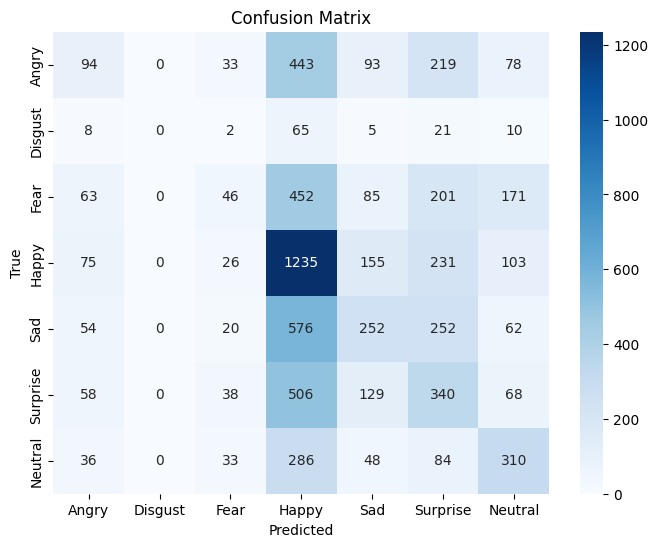

              precision    recall  f1-score   support

       Angry       0.24      0.10      0.14       960
     Disgust       0.00      0.00      0.00       111
        Fear       0.23      0.05      0.08      1018
       Happy       0.35      0.68      0.46      1825
         Sad       0.33      0.21      0.25      1216
    Surprise       0.25      0.30      0.27      1139
     Neutral       0.39      0.39      0.39       797

    accuracy                           0.32      7066
   macro avg       0.26      0.24      0.23      7066
weighted avg       0.30      0.32      0.28      7066



c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Skupljamo sve prave i predviđene vrednosti
y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Konfuziona matrica
cm = confusion_matrix(y_true, y_pred)

# Ako imaš 7 emocija (npr. FER2013 dataset)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3. Izveštaj (preciznost, recall, F1 po klasi)
print(classification_report(y_true, y_pred, target_names=class_names))
